# CNN implementation Attempt #2

This attempt will implement a CNN to predict the composer from a given midi file by using the piano roll data. Since CNNs excel at using data that more closely ressembles an image, using the feature data of each midi file is not as efficient. This will gather the sequence data for each midi file from the piano roll data, then represent that as a numpy array that closely resembles the shape of an image.

## Imports

Since I am using Google Colab for this notebook in order to utilize TPUs, We must pip install the dependencies that are not included, like the tensorflow tpu package and `pretty_midi`.

In [ ]:
!pip install tensorflow-tpu -f https://storage.googleapis.com/libtpu-tf-releases/index.html --force

In [ ]:
!pip install pretty_midi

In [21]:
# imports
import os
import pretty_midi
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from random import sample
from warnings import catch_warnings
from concurrent.futures import ThreadPoolExecutor
from random import sample

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [3]:
# tensorflow imports
from tensorflow import keras
from keras import Sequential, layers, utils, callbacks
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Input, Normalization, Flatten, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: 
Number of replicas: 8


Mount google drive to access the composer data.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fetch and Preprocess the data
Fetch the data and create a list of tuples that store the composer and the path to the specific file.

In [6]:
# DATA_DIR = "../selectedcomposers"

# google drive folder
DATA_DIR = "/content/drive/MyDrive/selectedcomposers"

composer_list = ["Bach", "Beethoven", "Chopin", "Mozart"]

# get all of the files so we can run a concurrent batch to speed up processing
file_label_pairs = []
for composer in os.listdir(DATA_DIR):
    composer_dir = os.path.join(DATA_DIR, composer)
    if not os.path.isdir(composer_dir):
        continue
    for root, _, files in os.walk(composer_dir):
        for fn in files:
            if fn.lower().endswith((".mid", ".midi")):
                file_label_pairs.append((os.path.join(root, fn), composer))

The following helper functions will get the piano roll data from the midi file, then it will generate an array of sequences from that data. We will use those sequences for the actual predictions. We also add padding to the sequences if they are too short to ensure a uniform shape.

In [7]:
frequency = 20
seq_size = frequency * 10

# pad the given sequence with zeros if it is too short
def add_padding(seq, x, missing):
  return np.hstack((seq, np.zeros((x, missing))))

# get all of the valid sequences from the provided piano roll data.
def get_sequences(piano_data):
  start = 0
  end = 0

  x, y = piano_data.shape
  sequences = []
  if(y < seq_size):
    sequence = add_padding(piano_data, x, seq_size-y)
    sequences.append(sequence)
  else:
    while(end < y):
      end = start + seq_size
      if end > y:
        sequence = piano_data[:,start:y]
        padded = add_padding(sequence, x, (start + seq_size - y))
        sequences.append(padded)
      else:
        sequence = piano_data[:,start:end]
        sequences.append(sequence)
      start += 10

  return sequences

# generate the midi object, remove any invalid notes,
# then get the sequences from the piano roll data
def get_seq_data(file_path):
  midi = pretty_midi.PrettyMIDI(file_path)
  midi.remove_invalid_notes()
  return get_sequences(midi.get_piano_roll(fs=frequency))

for each file that we have, get the create another list of tuples that store the composer name and the array of sequences from the midi file.

In [8]:
midi_data = []

for (path, composer) in file_label_pairs:
  midi_data.append({
    'composer': composer,
    'sequences': get_seq_data(path)
  })

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Turn the midi data that we retrieved into a dataframe. We have 1627 midi files from 4 total composers. With the most data from Bach and the least from Chopin.

In [9]:
midi_df = pd.DataFrame(midi_data)

print(f"\nTotal shape: {midi_df.shape}")
print("\nCount by composer:")
print(midi_df['composer'].value_counts())


Total shape: (1627, 2)

Count by composer:
composer
Bach         1024
Mozart        255
Beethoven     212
Chopin        136
Name: count, dtype: int64


We need to now unwrap the sequence data for each composer.

In [10]:
# get just the sequence data for each composer and the target row
seq_data = []
for midi in midi_data:
    for seq in midi['sequences']:
        seq_data.append({
            'sequence': np.transpose(seq),
            'composer': midi['composer']
        })

seq_df = pd.DataFrame(seq_data)
seq_df['composer'].value_counts()

,count
composer,
Bach,298248
Beethoven,201956
Mozart,199234
Chopin,57416


After unwrapping the sequence data, we now have about 750k rows, where ~300k rows of data from bach, ~200k are from beethoven and mozart, and 57k from Chopin. This is a lot of data and is incredibly unbalanced. This will cause our model to prefer bach over the other composers. To mitigate this, we can get 50k random rows for each composer for our model to use for training. This will greatly speed up convergence while still providing adequate data, ~400k rows of data, for training. We also ensure the data we train our model with is balanced.

In [12]:
rand_sample = 50000
sampled_df = seq_df.groupby("composer", group_keys=False).sample(n=rand_sample, random_state=511)
sampled_df['composer'].value_counts()

,count
composer,
Bach,50000
Beethoven,50000
Chopin,50000
Mozart,50000


Get the features and target from the dataframe and convert it into an array of values. These values mimic the shape of an image which is beneficial for the cnn to train with.

In [13]:
X = np.stack(sampled_df['sequence'].values)
y = sampled_df['composer'].values

# shuffle the dataset with replicable seed
indices = np.arange(X.shape[0])
np.random.seed(23)
np.random.shuffle(indices, )

X_shuffled = X[indices]
y_shuffled = y[indices]

encode the target values.

In [14]:
# label encode the labels
ohe = OneHotEncoder()
y = ohe.fit_transform(y_shuffled.reshape(-1, 1))
y = y.toarray()
y

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

## Train, Test, Validation split

Split the data that we have into a training, validation, and test set at a 80/10/10 ratio.

In [15]:
# split into train/test/val
TEST_TRAIN_SPLIT = 0.8
TEST_VAL_SPLIT = 0.1
total = len(X_shuffled)

# train, test, and val data
train_total = int(total * TEST_TRAIN_SPLIT)
test_val_total = int(total * (TEST_TRAIN_SPLIT + TEST_VAL_SPLIT))

X_train = X_shuffled[:train_total].copy()
y_train = y[:train_total].copy()
X_val = X_shuffled[train_total:test_val_total].copy()
y_val = y[train_total:test_val_total].copy()
X_test = X_shuffled[test_val_total:].copy()
y_test = y[test_val_total:].copy()

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test shapes: (160000, 200, 128) (20000, 200, 128) (20000, 200, 128)


For efficiency while rerunning the notebook, save the training data to a npz file. This caching allows us to only run the data fetching, preperation, and splitting once so we can more efficiently iterate on our model.

In [16]:
# Save the train, test, and val data to an external file.
np.savez_compressed(
    f'/content/drive/MyDrive/AAI-511/cnn_wav/data_splits.npz',
    X_train=X_train, y_train=y_train,
    X_val=X_val,     y_val=y_val,
    X_test=X_test,   y_test=y_test
)

only run the following cell if we plan on fetching the train test and validation sets from the cached file.

In [ ]:
# Fetch the train, test, and val data and load it in.
data = np.load('data_splits.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val   = data['X_val']
y_val   = data['y_val']
X_test  = data['X_test']
y_test  = data['y_test']

## train the model

We will train the CNN using tensorflow with multiple layers.

For each of our layers, we set the kernel_size to 3 and use the relu activation function. We also utilize causal padding. Causal padding ensures that our model will not "peek" into the future when making predicitions. This allows us to more consistently utilize the data that we are presenting it, while respecting the temporal order.

### Blocks

We have 6 Convolutional blocks.

Each block defines a number of filters to use, the dropout and max pooling.

We start with 256 filters, then half that to 128 then finaly half it again to 64.

We start with a large number of filters, 256, to capture a wide variety of temporal patterns. As we go deeper, we reduce to 128 then 64 filters, forcing our network to compress those many raw features into higher level abstractions.

We also add an aggressive dropout of 30% per convolutional layer. This zeros out 30% of the data to help reduce overfitting of our model.

Finally, we set the maxpooling to 2. This downsamples the time axis by two for every conv layer. This cuts the sequence length, reducing the amount of computations needed for deeper layers, while also acting like a bottleneck to help prevent overfitting.

After our Convolutional blocks, we flatten the data, which ensures the final feature map is a 1d vector.

we then create two dense fully connected layers, this helps to compact the data with the relu activation function for regularization. We add a 30% dropout for each of these layers as well. the final dense layer produces a probability distribution over each of the 4 composers.

### compiling the model

When we compile the model we use the adam optimizer with a learning rate of .1%. We also set the loss to track the categorical crossentropy.

In [28]:
# global training parameters
NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

with strategy.scope():
  cnn_model = Sequential()
  cnn_model.add(Conv1D(256, kernel_size=3, activation='relu', padding='causal'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(MaxPooling1D(2))
  cnn_model.add(Conv1D(256, kernel_size=3, activation='relu', padding='causal'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(MaxPooling1D(2))
  cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='causal'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(MaxPooling1D(2))
  cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='causal'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(MaxPooling1D(2))
  cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='causal'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(MaxPooling1D(2))
  cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='causal'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(MaxPooling1D(2))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(64, activation='relu'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(Dense(64, activation='relu'))
  cnn_model.add(Dropout(0.3))
  cnn_model.add(Dense(len(composer_list), activation='softmax'))

  # Compile the model
  cnn_model.compile(
      optimizer= keras.optimizers.Adam(learning_rate=LEARNING_RATE),
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy', 'precision', 'recall', 'f1_score']
  )

## Training the model

When we train the model we take a number of extra steps. First we add early stopping, this will stop the training when the categorical accuracy stops improving, and reverts the the epoch with the best weight.

We also set up checkpoints for our model. This will automatically save the model at each training epoch with the best model. This will help us for evaluation in the future so we do not have to retrain the model.

We also set the number of epochs to 50 with a batch size of 32.

In [ ]:
# Create the callback
early_stop = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5,
    mode='max',
    min_delta=0.0001,
    restore_best_weights=True
)

# setup checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
  filepath='/content/drive/MyDrive/AAI-511/best_cnn.keras',
  monitor='val_categorical_accuracy',
  mode='max',
  save_best_only=True
)

history = cnn_model.fit(
  X_train, y_train,
  validation_data=(X_val,y_val),
  epochs=NUM_EPOCHS,
  batch_size=BATCH_SIZE,
  callbacks=[early_stop, checkpoint]
)

Evaluating the trained model shows we have a categorical accuracy of 78.62%. This is pretty decent for a cnn with this type of data!

In [19]:
loss, cat_acc, precision, recall, f1 = cnn_model.evaluate(X_test, y_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - categorical_accuracy: 0.8206 - f1_score: 0.8206 - loss: 0.5611 - precision: 0.8900 - recall: 0.7161


- **Loss**: 0.6195  
  Measures the “distance” between the predicted probability distribution and the true labels. Lower loss indicates that our models predictions are closer to the ground truth.

- **Accuracy**: 0.7862 (78.62%)  
  The fraction of all predictions that our model got right. This gives a high level sense of overall performance.

  our accuracy tells us that our model predicted the correct composer about 3/4th of the time! Definitely better than what I can predict on my own!

- **Precision (macro-average)**: 0.8376 (83.76%)  
  Of all samples our model predicted as a given composer, what proportion were actually that composer. High precision means few false positives.

  Aprecision of 84% tells us that we had some false positives but the vast majority of the predictions were true positives.

- **Recall (macro-average)**: 0.6780 (67.80%)  
  Of all samples belonging to a composer, what proportion the model correctly identified. High recall means few false negatives.

  Of all the samples that belonged to a composer, about 68% were correctly identified.

  - **Per-Composer F1 Scores**  
  The F1 score is the harmonic mean of precision and recall for each class. Here are the values in the order returned by our label encoder (`[Bach, Beethoven, Chopin, Mozart]`):

| Composer   | F1 Score | Interpretation                                |
|------------|----------|-----------------------------------------------|
| **Bach**       | 0.8586   | our model had a strong balance of precision & recall for bach        |
| **Beethoven**  | 0.6922   | Moderate performance—o ur model misses more than half of true positives or has some false alarms  |
| **Chopin**     | 0.9345   | Excellent— our model almost never mislabels Chopin and rarely misses true Chopin pieces |
| **Mozart**     | 0.6657   | Lowest— our model struggles most with Mozart, either confusing it for other composers or missing many Mozart samples |



In [20]:
print(f'Loss: {loss}\nAccuracy: {cat_acc}\nPrecision: {precision}\nRecall: {recall},\nF1: {f1}')

Loss: 0.5610867738723755
Accuracy: 0.8205500245094299
Precision: 0.8900006413459778
Recall: 0.7160500288009644,
F1: [0.88744676 0.7366738  0.9251531  0.73313844]


In [22]:
import matplotlib.pyplot as plt
from itertools import cycle

# Compute predictions and true labels
y_prob = cnn_model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
classes = ohe.categories_[0]
n_classes = len(classes)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


In [24]:
# Classification report
report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

df_report.head()

,precision,recall,f1-score,support
Bach,0.907528,0.868235,0.887447,4804.00000
Beethoven,0.677894,0.806615,0.736674,5140.00000
Chopin,0.892851,0.959881,0.925153,5035.00000
Mozart,0.841548,0.649472,0.733138,5021.00000
accuracy,0.820550,0.820550,0.820550,0.82055


## Classification Report

Overall accuracy: **0.8206** on a balanced test set with ~5k support per class, this reflects the true multiclass performance rather than being driven by class imbalance.

### Per-composer metrics
- **Bach** — **P=0.9075**, **R=0.8682**, **F1=0.8874**  
  Strong across the board: few false positives and few misses.

- **Beethoven** — **P=0.6779**, **R=0.8066**, **F1=0.7367**  
  **High recall, lower precision** -> our model finds most Beethoven pieces but also **over-predicts** Beethoven. This means there are a high number of false positves.

- **Chopin** — **P=0.8929**, **R=0.9599**, **F1=0.9252**  
  Best class: very high recall and precision, our model distinguishes Chopin reliably.

- **Mozart** — **P=0.8415**, **R=0.6495**, **F1=0.7331**  
  **Good precision, lower recall** -> when our model predicts Mozart it is usually right, but it misses many true Mozart samples resulting in false negatives.

These metrics suggest that there is a slight weakness when it comes to prediciting Beethoven and Mozart, as there are a high number of false positives and negatives respectively. However, our model is very strong when it comes to predicting Chopin and Bach.


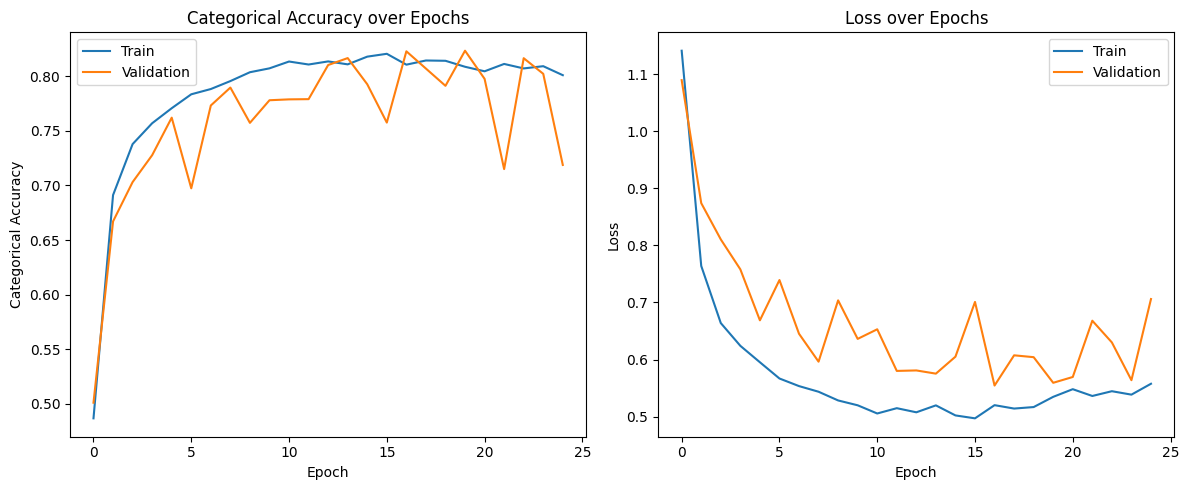

In [25]:
# Create a single figure with two subplots: Accuracy and Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(history.history['categorical_accuracy'], label='Train')
ax1.plot(history.history['val_categorical_accuracy'], label='Validation')
ax1.set_title('Categorical Accuracy over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Categorical Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Loss over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

The above graphs show us the increase in accuray and decrease in loss during training compared to the validation data that was provided. Overtime, those values started to get closer together however they were not perfect. We can also see that past epoch 15 our validation started to stall and slightly worsen. The high fluctuations in the validation indicate that the model was extremely sensitive to the data we gave it.

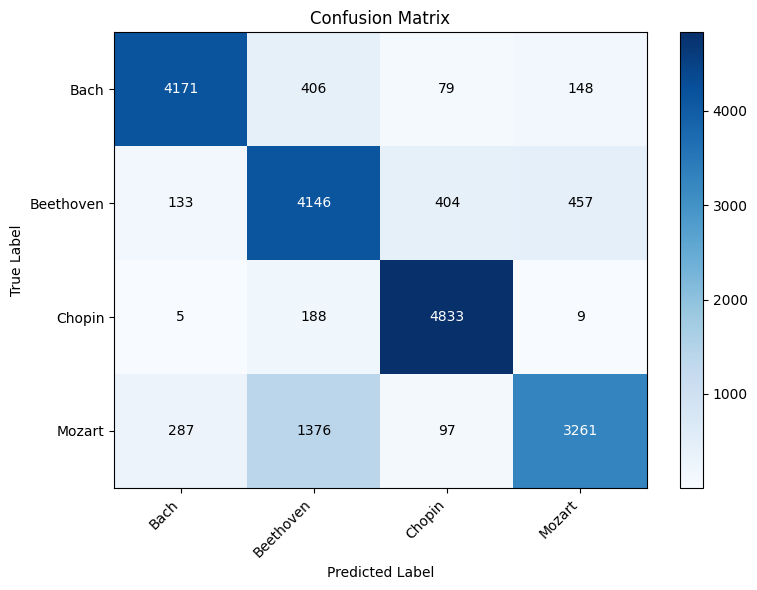

In [26]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', aspect='auto', cmap='Blues')
plt.colorbar(im, ax=ax)

tick_marks = np.arange(n_classes)
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# Annotate counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, f"{cm[i, j]:d}",
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()


The above confusion matrix shows how many instances of each true composer were predicted as each composer.

**Strong Diagonal**  
   - **Bach** → Bach: 4171  
   - **Beethoven** → Beethoven: 4146  
   - **Chopin** → Chopin: 4833  
   - **Mozart** → Mozart:  3261  

This strong diagonal tells us that our model did a decent job actually predicting the correct composer, however it struggled for certain composers. Specifically Mozart, Which was inccorectly predictied as Beethoven a number of times! We can also see that our model never Chopin as mozart, and only once for Bach, which is excellent! Meaning our model was able to clearly distinguish those two composers from bach very well.

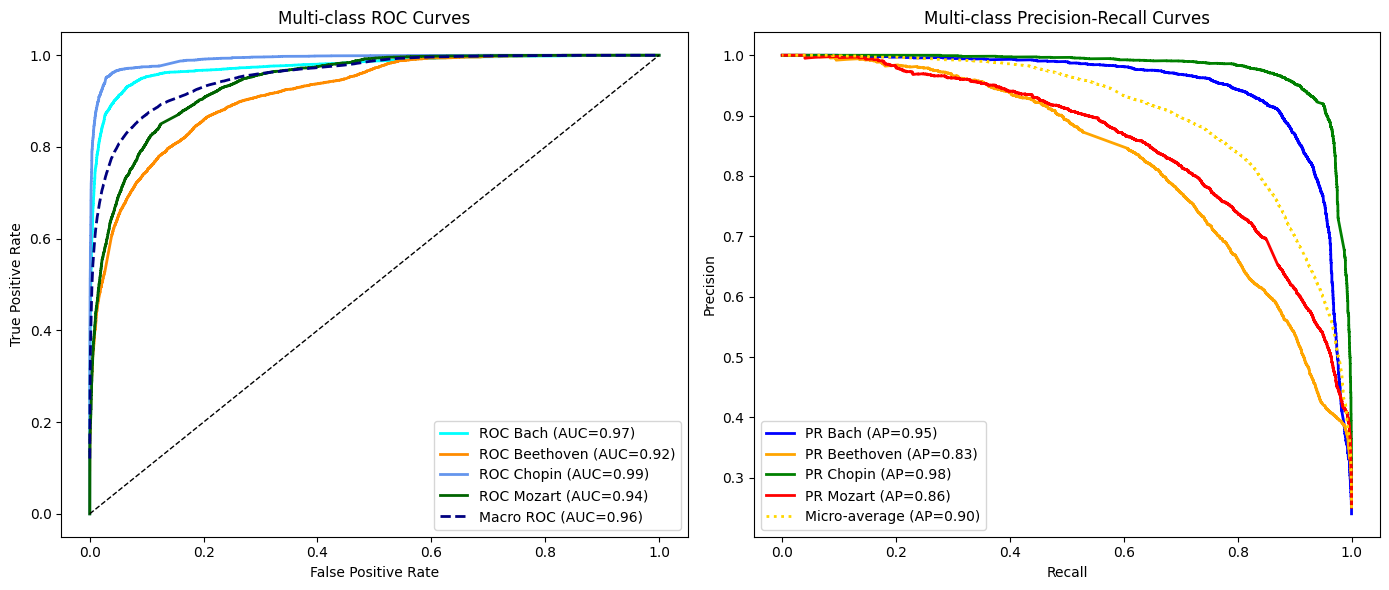

In [27]:
# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute Precision-Recall for each class
precision = dict()
recall = dict()
avg_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    avg_precision[i] = average_precision_score(y_test[:, i], y_prob[:, i])

# Compute micro-average Precision-Recall
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_prob.ravel())
avg_precision["micro"] = average_precision_score(y_test, y_prob, average="micro")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen'])
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr[i], tpr[i], color=color, lw=2,
              label=f'ROC {classes[i]} (AUC={roc_auc[i]:0.2f})')
ax1.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', lw=2,
          label=f'Macro ROC (AUC={roc_auc["macro"]:0.2f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Multi-class ROC Curves')
ax1.legend(loc='lower right')

# Plot Precision-Recall curves
colors = cycle(['blue', 'orange', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    ax2.plot(recall[i], precision[i], color=color, lw=2,
              label=f'PR {classes[i]} (AP={avg_precision[i]:0.2f})')
ax2.plot(recall["micro"], precision["micro"], color='gold', linestyle=':',
          label=f'Micro-average (AP={avg_precision["micro"]:0.2f})', lw=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Multi-class Precision-Recall Curves')
ax2.legend(loc='lower left')

plt.tight_layout()
plt.show()








The above graphs show the multi class ROC and precision recall curves for each composer.

### ROC

- **Bach (AUC = 0.97)**  
  The aqua curve hugs the top-left corner, indicating very high separability. Bach examples are distinguished from others with few false positives.

- **Beethoven (AUC = 0.91)**  
  The dark orange curve is lower, showing that Beethoven is harder to separate with more overlap with other composers, yielding a slight trade off between sensitivity and specificity.

- **Chopin (AUC = 0.99)**  
  The cornflowerblue curve is almost perfect. Chopin pieces are the easiest for the model to identify, with almost no confusion.

- **Mozart (AUC = 0.92)**  
  The dark green curve is strong but not as extreme as Chopins. Mozart is well separated, though there remains some false positive rate to achieve high recall.

- **Macro-average ROC (AUC = 0.95)**  
  The dashed navy curve averages all four class curves. An AUC of 0.95 indicates excellent overall discriminative ability across composers.

### Percision Vs Recall curves


- **Bach (AP = 0.94)**  
  The solid blue curve stays near the top, which indicates a high precision, for most recall levels. This means our model keeps false alarms low even as it captures more Bach examples.

- **Beethoven (AP = 0.80)**  
  The solid orange curve falls off more quickly, indicating that to capture more Beethoven samples and have a higher recall, our model must tolerate a larger drop in precision.

- **Chopin (AP = 0.98)**  
  The solid green curve is almost flat near precision=1.0, signifying nearly no false positives for any recall level until the extreme end—Chopin remains highly reliable.

- **Mozart (AP = 0.80)**  
  The solid red curve mirrors Beethovens behavior. Mozart classification requires trading off precision to gain recall, suggesting similar difficulty.

- **Micro-average PR (AP = 0.86)**  
  The dotted gold curve pools all classes. An AP of 0.86 reflects the aggregate precision recall balance, weighted by class frequency.
